In [27]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(horizon=[200, 400, 800],
                                 num_iters=[100, 500, 1000],
                                 chunk_size=[50, 100, 500])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 8500
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 3
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [4]:
#Set tasks

R = 2
#alpha = params['alpha']
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
total_attempts = 0
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task], n_attempts = generate_positive_definite_covariance(R=R, sigma_on=0.5,
                                                                                 sigma_off=0.5,
                                                                                 symmetry_factor=-1,
                                                                                 traceless=False, report_attempts=True)
    total_attempts += n_attempts
print(total_attempts)
sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
sigma_mn_all[:,:,1] = np.array([[0.4, 0.2], [-0.2, 0.4]])

920


In [5]:
N_W_samples = 1
C_emp_avg = 0
S_emp_avg = 0
z_ccov_emp_avg = 0

#lags window
dt = 0.1
T_window_emp = 80
dT_emp = 0.1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

D_changed = D.copy()
D_changed[0] = 1.8 * D[0]
D_changed[1] = 1.2 * D[1]
T_sim = 4000
for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D_changed, N)
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    #S_emp_avg += S_emp[:len(C_emp)] / N_W_samples
    
    ### --- Estimate Cz1 empirically --- ###
    
    r = r.cpu().numpy()
    Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]
    Z = Z - Z.mean(axis=1, keepdims=True)
    Z_ft = np.fft.rfft(Z[:,:,:], axis=1, norm='ortho')
    z_ccov = np.fft.irfft(np.einsum('awr, aws -> awrs', Z_ft, np.conj(Z_ft)), axis=1)
    z_ccov_emp_avg += z_ccov/N_W_samples

    Z_emp = np.concatenate([z_ccov_emp_avg[:,:int(T_window_emp/dt),:,:],
                            z_ccov_emp_avg[:,-int(T_window_emp/dt):,:,:]], axis=1)

In [ ]:
if prototype:
    dt = 0.05
    #D[0] *= 0.5
    #D[1] *= 2
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
    T_sim = 500
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200, noise_series=None)
    Z = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r) * D[:6,None,None]
    plt.plot(Z[1,:,0], Z[1,:,1])
    
        
    #r = r.cpu().numpy()
    #Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
    Z = Z - Z.mean(axis=1, keepdims=True)
    Z_ft = np.fft.rfft(Z[:,:,:], axis=1, norm='ortho')
    z_ccov = np.fft.irfft(np.einsum('awr, aws -> awrs', Z_ft, np.conj(Z_ft)), axis=1)
    #z_ccov_emp_avg += z_ccov/N_W_samples

In [6]:
import torch
import numpy as np
from torch import tensor

# ------------- Utility functions -------------
def phi_torch(x):
    """Saturating nonlinearity: erf((sqrt(pi)/2)*x)."""
    return torch.erf((torch.sqrt(torch.tensor(torch.pi, device=x.device)) / 2) * x)

def phi_prime_torch(x):
    """Derivative of erf((sqrt(pi)/2)*x) = exp(-(pi/4)*x^2)."""
    return torch.exp(-(torch.pi/4) * x**2)

def sample_gp_torch(cov, M, device, reg=1e-4):
    """Sample M trajectories from a GP with zero mean and covariance 'cov'."""
    T = cov.shape[0]
    L = torch.linalg.cholesky(cov + reg*torch.eye(cov.shape[0]).to(0).to(torch.float32))
    noise = torch.randn(M, T, device=device, dtype=torch.float32)
    return noise @ L.T  # shape (M,T)

def sample_weights_torch(M, M_star, R, cov_mn_list, device):
    """
    Sample the weight sets m^(μ*,r) and n^(μ*,r) for each condensed pattern.
    """
    if isinstance(cov_mn_list, list):
        covs = torch.stack(cov_mn_list, dim=0)  # shape: (M_star, R, R)
    else:
        covs = cov_mn_list
    I_R = torch.eye(R, device=device, dtype=torch.float32).unsqueeze(0).repeat(M_star, 1, 1)
    top = torch.cat([I_R, covs], dim=2)  # (M_star, R, 2R)
    bot = torch.cat([covs.transpose(1,2), I_R], dim=2)  # (M_star, R, 2R)
    cov_full = torch.cat([top, bot], dim=1)  # (M_star, 2R, 2R)
    mean = torch.zeros(M_star, 2*R, device=device, dtype=torch.float32)
    mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov_full)
    samples = mvn.sample((M,))  # shape: (M, M_star, 2R)
    m = samples[..., :R]
    n = samples[..., R:]
    return m, n

# ------------- The main tangent-linear integrators -------------
def integrate_x_with_jacobian(
    eta_x,          # shape (M,T)
    m,              # shape (M, M_star, R)
    z_condensed,    # shape (M_star, R, T)
    kappa_condensed_init,    # shape (M_star, R)
    R_z,            # shape (T,T)
    dt: float,
    horizon=None,
    init_noise_level=0
):
    """
    Integrate the x dynamics *and* compute d x(t)/d I_x(s) in one pass, 
    but truncate the convolution sums and Jacobian updates to 'horizon' steps.

    Suppose the x–dynamics is:
      x[t+1] = x[t] 
               + dt * ( -x[t] 
                         + sum_{μ*,r} [m^(μ*,r)*z^(μ*)_r(t)] 
                         + dt * Σ_{u=0}^{t} R_z[t,u]*phi(x[u])
                         + eta_x[t] )

    We'll skip older times if t-u > horizon. 
    Also, for the Jacobian, we skip impulses s < t - horizon + 1.

    Parameters:
      eta_x     : (M,T)
      m         : (M, M_star, R)
      z_condensed : (M_star, R, T)
      R_z       : (T,T)
      dt        : float
      horizon   : int or None. If None, use full sums. If int, skip older than horizon steps.
      kappa_condensed_init : (M_star, R)

    Returns:
      x     : (M,T)
      phi_x : (M,T)
      J_x   : (M,T,T)   # J_x[i,t,s] = ∂ x[i,t]/∂ I[i,s]
    """
    M, T = eta_x.shape
    device = eta_x.device

    # State and nonlinearity
    x = torch.zeros(M, T, device=device)
    phi_x = torch.zeros(M, T, device=device)
    # Jacobian: J_x[i,t,s] = partial x[i,t] wrt impulse at time s
    J_x = torch.zeros(M, T, T, device=device)

    # For convenience, define the "lower-triangular" version of R_z:
    Rz_lower = torch.tril(R_z)

    # Initialize
    init_noise = torch.randn(M).to(device)
    x[:, 0] = torch.einsum('imr, mr -> i', m, kappa_condensed_init) + init_noise_level * init_noise
    phi_x[:, 0] = torch.erf((torch.sqrt(torch.tensor(torch.pi, device=device)) / 2) * x[:, 0])

    for t in range(T - 1):
        # 1) main update
        # coupling from condensed patterns:
        #   sum_{μ*,r} m[i,μ*,r]* z_condensed[μ*,r,t]
        # shape(m) after summation
        coupling = torch.sum(m * z_condensed[:, :, t].unsqueeze(0), dim=(1, 2))

        # truncated sum for convolution: sum_{u = max(0, t-horizon+1) .. t}
        if horizon is None:
            u0 = 0
        else:
            u0 = max(0, t - horizon + 1)

        conv = 0.0
        # sum_{u=u0..t} R_z[t,u]*phi_x[:,u], then multiply by dt
        conv = dt * torch.sum(phi_x[:, u0:t+1] * Rz_lower[t, u0:t+1].unsqueeze(0), dim=1)

        # dxdt = (-x + coupling + conv + eta_x[t])
        dxdt = -x[:, t] + coupling + conv + eta_x[:, t]

        # Euler step
        x[:, t+1] = x[:, t] + dt * dxdt
        # Nonlinearity
        phi_x[:, t+1] = torch.erf((torch.sqrt(torch.tensor(torch.pi, device=device)) / 2) * x[:, t+1])

        # 2) derivative update for each s in [ max(0,t-horizon+1), .., t ]
        # For a purely Euler equation:
        #   x[t+1] = x[t] + dt * F(x[t]),
        # we get
        #   J_x[t+1,s] = J_x[t,s] + dt * dF/dx[t] * J_x[t,s].
        #
        # partial(F)/partial(x[t]) = -1 + dt*R_z[t,t]*phi'(x[t]) 
        # because conv includes dt * Σ_{u=0..t}..., only the term u=t depends on x[t].
        # Keep the same double–dt approach.

        dFdx = -1.0
        dFdx += dt * Rz_lower[t, t] * torch.exp(-(torch.pi/4) * x[:, t]**2)  # phi'(x[t])

        partial_x_next_wrt_x = 1.0 + dt * dFdx  # shape (M,)

        if horizon is None:
            s0 = 0
        else:
            s0 = max(0, t - horizon + 1)

        for s in range(s0, t+1):
            J_x[:, t+1, s] = partial_x_next_wrt_x * J_x[:, t, s]

        # If impulse at exactly time t enters x[t+1] directly => + dt
        J_x[:, t+1, t] += dt

    return x, phi_x, J_x

def build_M_z_batched(S_phi, D, C_mat, dt):
    """
    Build a batched (M, R*T, R*T) matrix M, where each slice M[i]
    corresponds to the feed-forward equation:
      z[i, t+1] = D[i]* dt * Σ_{u=0..t} [ S_phi[t,u]*z[i,u] ] @ C_mat[i]^T
    ignoring noise and impulses for now.

    We want:
      M[i, (t*R + r), (u*R + r')] = D[i]* dt * S_phi[t,u] * C_mat[i, r', r], 
      if u < t, else 0.
    (Strictly lower in time.)

    Returns:
      M_batched: shape (M, R*T, R*T).
    """
    device = C_mat.device
    M = D.shape[0]      # number of trajectories
    T = S_phi.shape[0]
    R = C_mat.shape[1]

    # 1) We'll first build a 5D array of shape (M, T, T, R, R),
    #    where M_5d[i,t,u,r,r'] = D[i]* dt * S_phi[t,u] * C_mat[i,r',r].
    # 2) Then we mask out the region u >= t (diagonal & above).
    # 3) Finally, we reshape to (M, T*R, T*R).

    # Expand S_phi to shape (1,T,T,1,1) so it can broadcast over (M, R, R).
    S_phi_5d = S_phi.view(1, T, T, 1, 1)  # (1,T,T,1,1)

    # Expand D to shape (M,1,1,1,1)
    D_5d = D.view(M, 1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

    # We want C_mat^T in the sense that for each i, c[r', r] => c^T[r, r'].
    # So let's do c^T = C_mat.transpose(1,2), shape (M,R,R).
    # Expand to shape (M,1,1,R,R) for broadcast.
    C_mat_T_5d = C_mat.transpose(1,2).unsqueeze(1).unsqueeze(2)  # (M,1,1,R,R)

    # Multiply everything elementwise:
    # shape => (M,T,T,R,R)
    M_5d = D_5d * dt * S_phi_5d * C_mat_T_5d

    # 2) Mask out diagonal & above: we only keep entries where u < t.
    # We'll define a (T,T) boolean mask for "u < t" => strictly lower triangle
    # (No +1 offset, so row t depends on col u only if u < t).
    mask_tril = torch.tril(torch.ones(T, T, device=device), diagonal=-1).bool()
    # shape => (1,T,T,1,1)
    mask_5d = mask_tril.view(1, T, T, 1, 1)
    M_5d = M_5d * mask_5d  # zero out u >= t

    # 3) Reshape from (M, T, T, R, R) to (M, R*T, R*T).
    # We'll flatten time & state together. The standard approach:
    #   row-index = t*R + r
    #   col-index = u*R + r'
    #
    # We can do a 2D reshape:
    #   M_5d[i].view(T*R, T*R)
    # but we must carefully place the T dimension before R dimension.
    M_batched = M_5d.permute(0,1,3,2,4).reshape(M, T*R, T*R)
    return M_batched

def invert_I_minus_M_batched(M_batched):
    """
    Given M_batched of shape (M, dim, dim),
    return the inverse of (I - M_batched[i]) for each i in [0..M-1].
    Result shape => (M, dim, dim).
    """
    M, dim, _ = M_batched.shape
    I = torch.eye(dim, dtype=M_batched.dtype, device=M_batched.device)
    I = I.unsqueeze(0).expand(M, dim, dim)  # shape (M,dim,dim)
    A = I - M_batched  # shape (M,dim,dim)
    # Batched inverse:
    A_inv = torch.linalg.inv(A)  # shape (M,dim,dim)
    return A_inv


# ------------- Update/Compute Order Parameters -------------
def update_order_parameters_x(phi_x):
    """C^phi(t,t') = 1/M sum_{i} phi_x[i,t]*phi_x[i,t']"""
    M, T = phi_x.shape
    return (phi_x.transpose(0,1) @ phi_x) / M  # (T,T)

def update_condensed_patterns(n, phi_x, D_condensed):
    """
    z^(μ*)_r(t) = average over i of n^(μ*,r)[i] * phi_x[i,t].
    shape(n) = (M, M_star, R), shape(phi_x)=(M,T)
    output shape = (M_star,R,T).
    """
    M, M_star, R = n.shape
    _, T = phi_x.shape
    # z_condensed[m_star, r, t] = sum_i n[i,m_star,r]*phi_x[i,t] / M
    z_condensed = torch.einsum('imr,it->mrt', n, phi_x) / M * D_condensed[:,None,None]
    return z_condensed

def update_order_parameters_z(z, alpha):
    """
    Q^z(t,t') = alpha * sum_r < z_r(t) z_r(t') >_M
    shape(z)=(M,R,T)
    """
    M, R, T = z.shape
    Qz_new = torch.zeros(T, T, device=z.device, dtype=z.dtype)
    for r in range(R):
        Qz_new += z[:, r, :].T @ z[:, r, :]
    Qz_new = alpha * Qz_new / M
    return Qz_new

def update_with_memory(O_old, O_new, gamma):
    return (1 - gamma)*O_old + gamma*O_new

# ------------- Final: Use J_x, J_z to get S_phi, R_z -------------
def compute_S_phi_from_J_x(x, J_x):
    """
    S^phi(t,s) = (1/M) * sum_i [ phi'(x[i,t]) * J_x[i,t,s] ]
    where x.shape=(M,T), J_x.shape=(M,T,T).
    """
    M, T = x.shape
    phi_prime = phi_prime_torch(x)  # shape (M,T)
    # Einsum: 'mt, mts -> ts' sums over the batch dimension 'm' and matches 't',
    # leaving 't,s' as output.
    S_phi = torch.einsum('mt,mts->ts', phi_prime, J_x) / M
    return S_phi

def compute_Rz_from_inverse_batched(I_minus_M_inv, D, C_mat, alpha=1.0):
    """
    Given:
      I_minus_M_inv: (M, R*T, R*T) = [ (I - M_i)^(-1) ] for each trajectory i
      D            : (M,)           scalars
      C_mat        : (M,R,R)        coupling matrices
      alpha        : float          global scaling

    We interpret I_minus_M_inv[i] as the Jacobian J_z[i], 
    i.e. partial z[i,t,r]/partial I[i,s,r'] in a flattened form.

    Then:
      R^z(t,s) = alpha * average_i [ 
                   D[i] * Σ_{r,r'} C_mat[i,r,r'] * J_z[i,t,s,r,r']
                 ].

    Returns:
      R_z_est: (T,T) torch.Tensor
    """
    M, dim, dim2 = I_minus_M_inv.shape
    assert dim == dim2, "Inverse must be square."
    # We deduce R and T from dim=R*T.
    # For simplicity, assume you know R from C_mat.shape, then T = dim//R.
    R = C_mat.shape[1]
    T = dim // R
    assert R*T == dim, f"dim={dim} not divisible by R={R}"

    # 1) Reshape from (M, R*T, R*T) -> (M, T, R, T, R)
    #    so that indexing is: J_z[i, t, r, s, r'] = partial z[i,t,r]/partial I[i,s,r'].
    # 2) Permute to (M, T, T, R, R), i.e. J_z[i,t,s,r,r'].
    # Row index = t*R + r, col index = s*R + r'.
    J_z_5d = I_minus_M_inv.view(M, T, R, T, R)  # shape (M,T,R,T,R)
    # reorder dims to (M, t, s, r, r')
    J_z_5d = J_z_5d.permute(0, 1, 3, 2, 4)      # shape (M, T, T, R, R)

    # 3) Multiply by C_mat[i,r,r'] and sum over (r,r')
    #    We'll do a broadcast multiply and sum along the last two dims.
    #    Then multiply by D[i], average over i, and multiply by alpha.
    #
    # C_mat[i] has shape (R,R). We want to broadcast it as (M,1,1,R,R).
    # J_z_5d is (M,T,T,R,R). The product is (M,T,T,R,R).
    # Summation over (r,r') => (M,T,T).
    temp = (C_mat.unsqueeze(1).unsqueeze(1) * J_z_5d).sum(dim=(4,3))  # shape (M,T,T)

    # Multiply by D[i], shape => (M,) => (M,1,1)
    temp = temp * D.view(M, 1, 1)  # shape (M,T,T)

    # Average over i => (T,T), then multiply by alpha
    R_z_est = alpha * temp.mean(dim=0)  # shape (T,T)

    return R_z_est

def compute_Qz_from_inverse_batched(
    I_minus_M_inv,  # (M, R*T, R*T)
    D,              # (M,)
    C_phi,          # (T,T)
    R,              # int, dimension of z_r
    alpha=1.0
):
    r"""
    Compute
    
      Q^z(t,t') = α * (1/M) * Σᵢ [ D[i]^2 * Σᵣ Cov(zᵢ(t,r), zᵢ(t',r)) ]

    using a fully manual, nested–loop approach that accumulates
    one scalar at a time. This avoids large intermediate tensors.

    Here zᵢ(t,r) = Σ_{u,p} Jᵣ[i,t,r,u,p] * ηᵢ[u,p],
    with Cov(ηᵢ[u,p], ηᵢ[v,p']) = δₚₚ' * D[i]^2 * C_phi[u,v].

    Parameters
    ----------
    I_minus_M_inv : (M, R*T, R*T) torch.Tensor
        Each slice i is (I - Mᵢ)⁻¹ for that trajectory.
    D : (M,) torch.Tensor
        Noise amplitude scalars for each trajectory i.
    C_phi : (T,T) torch.Tensor
        Temporal covariance kernel for ηᵢ.
    R : int
        The z–dimension, so T = (dim // R).
    alpha : float
        Global scaling factor.

    Returns
    -------
    Q_z : (T,T) torch.Tensor
        The ensemble–averaged Q^z(t,t').
    """
    device = I_minus_M_inv.device
    dtype = I_minus_M_inv.dtype

    M, dim, dim2 = I_minus_M_inv.shape
    assert dim == dim2, "I_minus_M_inv must be square in last two dims."
    T = dim // R
    assert R * T == dim, f"dim={dim} not divisible by R={R}"

    # Reshape to (M, T, R, T, R):
    # J_z_5d[i, t, r, u, p] = ∂zᵢ(t,r)/∂ηᵢ(u,p).
    J_z_5d = I_minus_M_inv.view(M, T, R, T, R)

    # We'll accumulate Q_z(t,t') in a T×T matrix, summing over all i and r.
    Q_z = torch.zeros(T, T, device=device, dtype=dtype)
    
    # We'll define D² and store it as shape (M,) for the einsum.
    D_sq = (D**2).view(M, 1, 1, 1, 1)  # shape (M, 1, 1, 1, 1)
    
    tmp = torch.einsum('mtrTR, Ts -> mtrsR', J_z_5d, C_phi)
    tmp = torch.einsum('mtrsR, mTrsR -> mtrTR', J_z_5d, tmp)
    tmp = tmp.sum(dim=(2,4))
    
    return alpha * (D_sq.view(M, 1, 1) * tmp).mean(0)


def invert_I_minus_M_in_chunks(M_batched, chunk_size=50):
    """
    M_batched: (M, dim, dim) = full feed–forward matrices for M trajectories.
    chunk_size: how many trajectories to invert at once.

    Returns: K_inv of shape (M, dim, dim), 
             the batched inverse of [I - M_batched[i]] for each i.
    """
    M_total, dim, dim2 = M_batched.shape
    assert dim == dim2, "M_batched must be square in last two dims."

    device = M_batched.device
    dtype = M_batched.dtype

    # Build an identity of shape (dim, dim)
    I_mat = torch.eye(dim, dtype=dtype, device=device)

    # We'll allocate space for the final inverse
    K_inv = torch.empty_like(M_batched)  # shape (M, dim, dim)

    # Invert in chunks
    start = 0
    while start < M_total:
        end = min(start + chunk_size, M_total)
        subM = end - start

        # A_sub = I - M_batched for that chunk
        K_sub = I_mat.unsqueeze(0).expand(subM, dim, dim) - M_batched[start:end]
        # shape (subM, dim, dim)

        # Invert
        K_sub_inv = torch.linalg.inv(K_sub)  # shape (subM, dim, dim)

        # Store
        K_inv[start:end] = K_sub_inv
        start = end

    return K_inv



# ------------- Main DMFT with on-the-fly derivative -------------
def simulate_dmft_torch_with_tangent(num_iterations=10, T=50, dt=0.1, M=10, M_star=2, R=3, gamma=0.1, alpha=1.0,
                                     device=None, cov_mn_list=None, D_condensed=None, kappa_condensed_init=None,
                                     D_z_all=None, C_mat_all=None,
                                     init_order_parameters=None, chunk_size=200, horizon=None, init_noise_level=0):
    """
    A single pass approach: each iteration, we:
      1) sample GP noise for x
      2) sample m,n for condensed patterns
      3) integrate x plus its derivative wrt impulses -> get x, phi_x, J_x
      4) from J_x, compute S^phi
      5) update z_condensed
      6) sample GP noise for z
      7) integrate z plus its derivative wrt impulses -> get z, J_z
      8) from J_z, compute R^z
      9) from z, compute Q^z
      10) from x, compute C^phi
      11) update all order params with memory
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize order parameters
    if init_order_parameters is None:
        C_phi = torch.eye(T, device=device)
        S_phi = torch.zeros(T, T, device=device)
        z_condensed = torch.zeros(M_star, R, T, device=device)
        Q_z = torch.eye(T, device=device)
        R_z = torch.zeros(T, T, device=device)
    else:
        C_phi, S_phi, z_condensed = init_order_parameters

    if cov_mn_list is None:
        cov_mn_list = [torch.eye(R, device=device) for _ in range(M_star)]
    if D_condensed is None:
        D_condensed = torch.ones(M_star, device=device)
    if kappa_condensed_init is None:
        kappa_condensed_init = torch.zeros(M_star, R, device=device)
    if D_z_all is None:
        D_z_all = torch.ones(M, device=device)
    if C_mat_all is None:
        C_mat_all = torch.eye(R, device=device).unsqueeze(0).repeat(M,1,1)

    for it in range(num_iterations):
        print(f"DMFT iteration {it+1}/{num_iterations}")

        try:
            
            
            ### --- Update z statistics
            
            Q_z = torch.zeros(T, T, device=device)
            R_z = torch.zeros(T, T, device=device)
            assert M % chunk_size == 0
            n_chunks = M // chunk_size
            for i_chunk in range(n_chunks):
                D_z_batch = D_z_all[i_chunk*chunk_size:(i_chunk+1)*chunk_size]
                C_mat_batch = C_mat_all[i_chunk*chunk_size:(i_chunk+1)*chunk_size]
                M_batch = build_M_z_batched(S_phi, D_z_batch, C_mat_batch, dt)
                K_inv_batch = invert_I_minus_M_in_chunks(M_batch, chunk_size=chunk_size)
                Q_z += compute_Qz_from_inverse_batched(K_inv_batch, D_z_batch, C_phi, R, alpha=alpha) / n_chunks
                R_z += compute_Rz_from_inverse_batched(K_inv_batch, D_z_batch, C_mat_batch, alpha=alpha) / n_chunks
            
            # ---- x part ----
            eta_x = sample_gp_torch(Q_z, M, device)  # shape (M,T)
            m, n = sample_weights_torch(M, M_star, R, cov_mn_list, device)
            # Integrate x + derivative
            S_phi_new = torch.zeros(T, T, device=device)
            C_phi_new = torch.zeros(T, T, device=device)
            z_condensed_new = torch.zeros(M_star, R, T, device=device)
            for i_chunk in range(n_chunks):
                eta_x_batch = eta_x[i_chunk*chunk_size:(i_chunk+1)*chunk_size]
                m_batch = m[i_chunk*chunk_size:(i_chunk+1)*chunk_size]
                n_batch = n[i_chunk*chunk_size:(i_chunk+1)*chunk_size]
                x, phi_x, J_x = integrate_x_with_jacobian(eta_x_batch, m_batch, z_condensed, kappa_condensed_init,
                                                          R_z, dt, horizon=horizon, init_noise_level=init_noise_level)
                S_phi_new += compute_S_phi_from_J_x(x, J_x) / n_chunks
                C_phi_new += update_order_parameters_x(phi_x) / n_chunks
                z_condensed_new += update_condensed_patterns(n_batch, phi_x, D_condensed) / n_chunks

            # --- memory updates ---
            S_phi = update_with_memory(S_phi, S_phi_new, gamma)
            C_phi = update_with_memory(C_phi, C_phi_new, gamma)
            z_condensed = update_with_memory(z_condensed, z_condensed_new, gamma)

        except KeyboardInterrupt:
            return C_phi, S_phi, z_condensed

    return C_phi, S_phi, z_condensed

In [20]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")

# Simulation parameters
#num_iterations = params['num_iters']  # DMFT iterations
num_iterations = 50
T = 1000  # time steps (keep T modest for Jacobian computation)
#horizon = params['horizon']
horizon = 80
dt = 0.1  # Euler time step
M = 500  # number of trajectories per process
M_star = 2  # number of condensed patterns
R = 2  # dimensionality of condensed patterns
gamma = 0.2  # memory parameter

# For x dynamics: sample weights m and n (using identity covariances).
cov_mn_list = [torch.tensor(sigma_mn_all[:,:,0], device=device).to(torch.float32),
               torch.tensor(sigma_mn_all[:,:,1], device=device).to(torch.float32)]
m_batch, n_batch = sample_weights_torch(M, M_star, R, cov_mn_list, device)

# Initialize condensed patterns with zeros.
z_condensed = torch.zeros(M_star, R, T, device=device)
kappa_condensed_init = torch.zeros(M_star, R, device=device)
kappa_condensed_init[0,0] = 1

# For z dynamics: per–trajectory scaling factors and coupling matrices.
D_changed = D.copy()
D_changed[0] = 1.8 * D[0]
D_changed[1] = 1.2 * D[1]
D_z_all = torch.tensor(D_changed, device=device)[-M:].to(torch.float32)
C_mat_all = torch.tensor(sigma_mn_all, device=device).swapaxes(0,2).swapaxes(1,2)[-M:,:,:].to(torch.float32)
#C_mat_all = torch.eye(R, device=device).unsqueeze(0).repeat(M, 1, 1)

# Run the DMFT simulation.
print("Running DMFT simulation...")
C_phi, S_phi, z_condensed = simulate_dmft_torch_with_tangent(
    num_iterations=num_iterations,
    T=T,
    dt=dt,
    M=M,
    M_star=M_star,
    R=R,
    gamma=gamma,
    alpha=alpha,
    device=device,
    cov_mn_list=cov_mn_list,
    D_condensed=torch.tensor(D_changed, device=device)[:2].to(torch.float32),
    kappa_condensed_init=kappa_condensed_init,
    D_z_all=D_z_all,
    C_mat_all=C_mat_all,
    chunk_size=100,
    init_noise_level=0
)

Running DMFT simulation...
DMFT iteration 1/50
DMFT iteration 2/50
DMFT iteration 3/50
DMFT iteration 4/50
DMFT iteration 5/50
DMFT iteration 6/50
DMFT iteration 7/50
DMFT iteration 8/50
DMFT iteration 9/50
DMFT iteration 10/50
DMFT iteration 11/50
DMFT iteration 12/50
DMFT iteration 13/50
DMFT iteration 14/50
DMFT iteration 15/50
DMFT iteration 16/50
DMFT iteration 17/50
DMFT iteration 18/50
DMFT iteration 19/50
DMFT iteration 20/50
DMFT iteration 21/50
DMFT iteration 22/50
DMFT iteration 23/50
DMFT iteration 24/50
DMFT iteration 25/50
DMFT iteration 26/50
DMFT iteration 27/50
DMFT iteration 28/50
DMFT iteration 29/50
DMFT iteration 30/50
DMFT iteration 31/50
DMFT iteration 32/50
DMFT iteration 33/50
DMFT iteration 34/50
DMFT iteration 35/50
DMFT iteration 36/50
DMFT iteration 37/50
DMFT iteration 38/50
DMFT iteration 39/50
DMFT iteration 40/50
DMFT iteration 41/50
DMFT iteration 42/50
DMFT iteration 43/50
DMFT iteration 44/50
DMFT iteration 45/50
DMFT iteration 46/50
DMFT iteration 4

In [26]:
M = 1000
D_z_all = torch.tensor(D_changed, device=device)[-M:].to(torch.float32)
C_mat_all = torch.tensor(sigma_mn_all, device=device).swapaxes(0,2).swapaxes(1,2)[-M:,:,:].to(torch.float32)
C_phi, S_phi, z_condensed = simulate_dmft_torch_with_tangent(
    num_iterations=5,
    T=T,
    dt=dt,
    M=M,
    M_star=M_star,
    R=R,
    gamma=gamma,
    alpha=alpha,
    device=device,
    cov_mn_list=cov_mn_list,
    D_condensed=torch.tensor(D_changed, device=device)[:2].to(torch.float32),
    kappa_condensed_init=kappa_condensed_init,
    D_z_all=D_z_all,
    C_mat_all=C_mat_all,
    chunk_size=100,
    init_noise_level=0,
    init_order_parameters=[C_phi, S_phi, z_condensed]
)

DMFT iteration 1/5


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.49 GiB. GPU 0 has a total capacty of 44.34 GiB of which 444.81 MiB is free. Including non-PyTorch memory, this process has 43.90 GiB memory in use. Of the allocated memory 42.92 GiB is allocated by PyTorch, and 650.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# plt.imshow(S_phi.cpu().numpy())

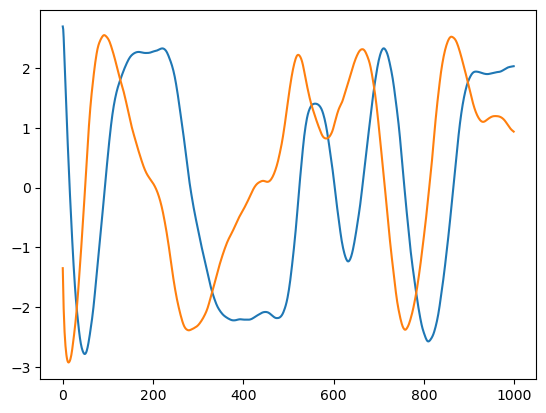

In [25]:
plt.plot(z_condensed.cpu().numpy()[0,0])
plt.plot(z_condensed.cpu().numpy()[0,1])
# plt.plot(Z[0,:500,0]/np.sqrt(N))
# plt.plot(Z[0,:500,1]/np.sqrt(N))

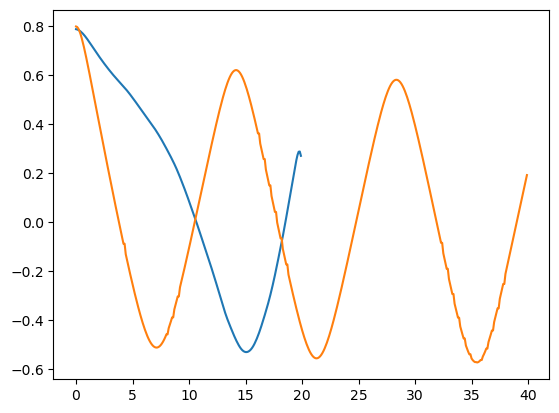

In [22]:
time_vec = np.arange(0, 40, 0.1)
plt.plot(time_vec[:200], C_phi.cpu().numpy()[200,199::-1])
plt.plot(time_vec, C_emp_avg[:len(time_vec)])

In [ ]:
#  C_phi, S_phi, Q_z, R_z, z_condensed = simulate_dmft_torch_with_tangent(
#         num_iterations=num_iterations,
#         T=T,
#         dt=dt,
#         M=M,
#         M_star=M_star,
#         R=R,
#         gamma=gamma,
#         alpha=alpha,
#         device=device,
#         cov_mn_list=cov_mn_list,
#         D_condensed=torch.tensor(D_changed, device=device)[:2].to(torch.float32),
#         D_z_all=D_z_all,
#         C_mat_all=C_mat_all,
#         init_order_parameters=[C_phi, S_phi, Q_z, R_z, z_condensed]
#     )

In [ ]:
processed_data = np.array([C_phi.cpu().numpy(), S_phi.cpu().numpy()])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': None,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [26]:
###Truncate file above
file_name = 'full_numerical'
job_name = 'second_tt_attempt'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook full_numerical.ipynb to script
[NbConvertApp] Writing 87843 bytes to full_numerical.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b4e2afb5c10> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b4e2afb5c10> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [27]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='misc')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='misc', lkumar=True)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/second_tt_attempt/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/LDR_dim/
mft-theory/LDR_dim/__init__.py
mft-theory/LDR_dim/condensed_tasks.py
mft-theory/LDR_dim/extensive_tasks.py
mft-theory/LDR_dim/solve_ldr.ipynb
mft-theory/LDR_dim/util.py
mft-theory/LDR_dim/LDR-dim/
mft-theory/LDR_dim/LDR-dim/__init__.py
mft-theory/LDR_dim/LDR-dim/solve_ldr.ipynb
mft-theory/LDR_dim/LDR-dim/util.py
mft-theory/clus

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
!ls -t ../job_scripts/

In [5]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'second_tt_attempt'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='misc')

In [6]:
theory_results[0]

{'horizon': [200, 400, 800],
 'num_iters': [100, 500, 1000],
 'chunk_size': [50, 100, 500],
 'i_seed': [0, 1, 2, 3, 4]}

In [7]:
theory_results[1].shape

(3, 3, 3, 5, 2, 800, 800)

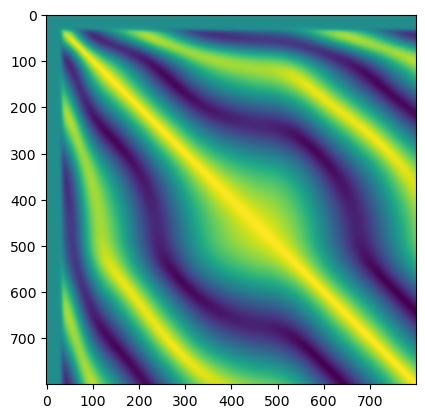

In [24]:
plt.imshow(theory_results[1][0,2,2,4,0])

In [ ]:
plt.imshow(theory_results[1][0,1,0,0,:,:])

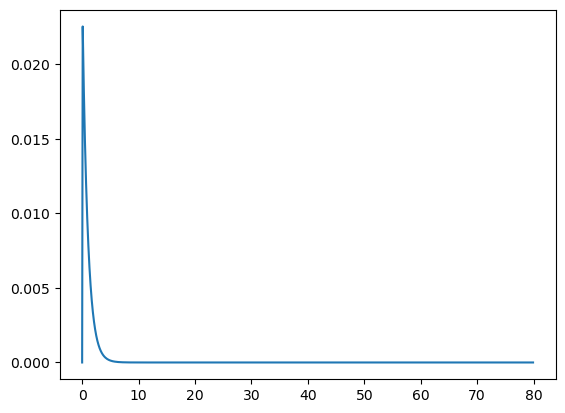

In [49]:
plt.plot(time_vec, theory_results[1][2,1,2,4,1,-1,::-1])

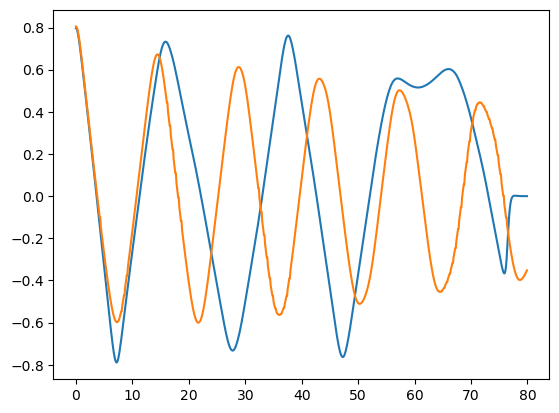

In [48]:
time_vec = np.arange(0, 80, 0.1)
plt.plot(time_vec, theory_results[1][2,1,2,4,0,-1,::-1])
plt.plot(time_vec, C_emp_avg[:len(time_vec)])

In [ ]:
i_alpha = 0
i_g = 2
i_N = 1
i_sigma_off = 2
i_seed = 1
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
# ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 0, :200])
# ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :200])
# ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 2, :2400])
# ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 3, :2400])
dt = 0.05
time_1 = np.arange(0, 10, dt)
time_2 = np.arange(0, 60, dt)
ax[0].plot(time_1, theory_results[1][i_sigma_off, i_seed, 1, :200], color='#E69629')
#ax[0].plot(time_1, theory_results[1][i_sigma_off, i_seed, 0, :200], color='k', linestyle='--')
ax[0].legend(['sim'])#, 'theory'])
ax[1].plot(time_2, theory_results[1][i_sigma_off, i_seed, 3, :1200], color='#E69629')
#ax[1].plot(time_2, theory_results[1][i_sigma_off, i_seed, 2, :1200], color='k', linestyle='--')
ax[0].set_title(r'$S^\phi(\tau)$')
ax[1].set_title(r'$C^\phi(\tau)$')
ax[0].set_xlabel(r'$\tau$')
ax[1].set_xlabel(r'$\tau$')
ax[0].set_yticks([0, 0.075, 0.15])
ax[1].set_yticks([0, 0.4, 0.8])
plt.tight_layout()
fig.savefig('figs/S_C_no_theory_fit.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 0, :])
ax[0].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :])
ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 2, :])
ax[1].plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 3, :])

In [ ]:
i_sigma_off = 2
#network properties size
#N = theory_results[0]['N'][i_N]
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
#g = theory_results[0]['g'][i_g]
g = 5
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

R = 2
#alpha = theory_results[0]['alpha'][i_alpha]
alpha = 0.5
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

#smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][i_sigma_off, i_seed, 0, :], dtype=torch.float32).to(0)
C = torch.tensor(theory_results[1][i_sigma_off, i_seed, 2, :], dtype=torch.float32).to(0)
N_t = C.shape[0]
#T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)
C_w = uni_rfft(C, dt)

In [ ]:
### --- bifurcation analysis --- ###
sigma_mn_all = np.zeros((R, R, N_tasks))
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.5,
                                                                     sigma_off=1.5,
                                                                     symmetry_factor=-1)
sigma_mn_all[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
Crr = sigma_mn_all[:,:,0]
SA = np.max(np.real(D[0]*np.linalg.eigvals(Crr) * S_.cpu().numpy()[0]*(np.sqrt(2*np.pi))))

In [ ]:
SA

In [ ]:
T_sim = 50
dt = 0.05
xs = []
rs = []
x0 = None
Ds = np.arange(1/SA - 0.2, 1/SA + 1, 0.1)
W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N, seed=0)
for D_factor in Ds:

    D_changed = D.copy()
    D_changed[0] = D[0] * D_factor

    # Multiply loadings_m by D
    D_tensor = torch.from_numpy(D_changed.astype(np.float32)).to(0)  # (N_tasks,)
    loadings = torch.from_numpy(all_loadings.astype(np.float32)).to(0)
    loadings_m = loadings[:, :, :R]  # (N_tasks, N, R)
    loadings_n = loadings[:, :, R:]  # (N_tasks, N, R)
    D_expanded = D_tensor[:, None, None]  # (N_tasks, 1, 1)
    loadings_m_weighted = D_expanded * loadings_m  # (N_tasks, N, R)

    # Reshape loadings_m_weighted and loadings_n to (N, N_tasks * R)
    loadings_m_weighted_flat = loadings_m_weighted.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)
    loadings_n_flat = loadings_n.permute(1, 0, 2).reshape(N, -1)  # (N, N_tasks * R)

    # Compute W = loadings_m_weighted_flat @ loadings_n_flat.T
    W_ = loadings_m_weighted_flat @ loadings_n_flat.T  # (N, N)
    
    x, r = sample_activity(T_sim=T_sim, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=True, T_save_delay=0, noise_series=None)
    x0 = torch.tensor(x[-1]).to(torch.float).to(0)[None,:]
    xs.append(x)
    rs.append(r)
x = np.concatenate(xs, axis=0)
r = np.concatenate(rs, axis=0)
Z_hat = np.einsum('air, ti -> atr', all_loadings[:6, :, 2:4], r)
plt.figure(figsize=(10, 2))
plt.plot(Z_hat[0,:,0])
plt.plot(Z_hat[0,:,1])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')
plt.figure(figsize=(10, 2))
plt.plot(Z_hat[1,:,0])
plt.plot(Z_hat[1,:,1])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')
plt.figure(figsize=(10, 2))
plt.plot(x[:,0])
plt.plot(x[:,2])
for i in range(len(Ds) + 1):
    plt.axvline(x=i*int(T_sim/dt), color='k', linestyle='--')

In [ ]:
np.savez('multi_task_elife/packaged_results/bifurcation_traces.npz', x=x[:,:10], r=r[:,:10], Z_hat=Z_hat, Dfs=Ds)

In [ ]:
!du -sh multi_task_elife/packaged_results/bifurcation_traces.npz

In [ ]:
Crr = np.array([[0.8, -0.4],[0.4, 0.8]])
#Crr = Crr
#Crr = Crr.T
#T = len(C_phi)
#t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
#sampfreq = 1/dT
#w = 2*np.pi*sampfreq*t_indices/T
S_omega = np.sqrt(2*np.pi)*S_.cpu().numpy()[:,None,None]
M_inv = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr[None,:,:]*S_omega)
M_invT = np.linalg.inv(np.eye(2)[None,:,:] - D[0]*Crr.T[None,:,:]*S_omega.conj())
z_ccov = np.zeros_like(M_inv)
for w in range(z_ccov.shape[0]):
    z_ccov[w] = D[0]**2 * M_inv[w,:,:].dot(M_invT[w,:,:]) * C_w[w].cpu().numpy()
z_ccov_w = torch.from_numpy(z_ccov).to(0)
z_ccov_T = uni_irfft(z_ccov_w, 0.05, axis=0)
#z_ccov_T = z_ccov_T.cpu().numpy()

In [ ]:
z_ccov_avg = theory_results[1][i_sigma_off, i_seed, :, :].T
T = z_ccov_T.shape[0]

i_task = 0
acov_T_11 = torch.cat([z_ccov_T[:,0,0][T//2:], z_ccov_T[:,0,0][:T//2]]).cpu().numpy()
acov_T_22 = torch.cat([z_ccov_T[:,1,1][T//2:], z_ccov_T[:,1,1][:T//2]]).cpu().numpy()
ccov_T_12 = torch.cat([z_ccov_T[:,1,0][T//2:], z_ccov_T[:,1,0][:T//2]]).cpu().numpy()
ccov_T_21 = torch.cat([z_ccov_T[:,0,1][T//2:], z_ccov_T[:,0,1][:T//2]]).cpu().numpy()
acov_avg_11 = np.concatenate([z_ccov_avg[:,4+4*i_task][-T//2:], z_ccov_avg[:,4+4*i_task][:T//2]])
acov_avg_22 = np.concatenate([z_ccov_avg[:,5+4*i_task][-T//2:], z_ccov_avg[:,5+4*i_task][:T//2]])
ccov_avg_12 = np.concatenate([z_ccov_avg[:,6+4*i_task][-T//2:], z_ccov_avg[:,6+4*i_task][:T//2]])
ccov_avg_21 = np.concatenate([z_ccov_avg[:,7+4*i_task][-T//2:], z_ccov_avg[:,7+4*i_task][:T//2]])

In [ ]:
acov_T_11.shape

In [ ]:
fig, ax = plt.subplots(2, 2)
time_vec = np.arange(-len(acov_avg_11)*dt/2, len(acov_avg_11)*dt/2, dt)
ax[0,0].plot(time_vec, acov_avg_11, color='#AC85BC')
#ax[0,0].plot(time_vec, acov_T_11, color='k', linestyle='--')
ax[1,1].plot(time_vec, acov_avg_22, color='#AC85BC')
#ax[1,1].plot(time_vec, acov_T_22, color='k', linestyle='--')
ax[0,1].plot(time_vec, ccov_avg_21, color='#AC85BC')
#ax[0,1].plot(time_vec, ccov_T_12, color='k', linestyle='--')
ax[1,0].plot(time_vec, ccov_avg_12, color='#AC85BC')
#ax[1,0].plot(time_vec, ccov_T_21, color='k', linestyle='--')
ax[0,0].set_title(r'$C^z_{11}(\tau)$')
ax[0,1].set_title(r'$C^z_{12}(\tau)$')
ax[1,0].set_title(r'$C^z_{21}(\tau)$')
ax[1,1].set_title(r'$C^z_{22}(\tau)$')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$')
        ax[i,j].set_xlim([-50, 50])
ax[0,0].legend(['sim'])#, 'theory'])
plt.tight_layout()
fig.savefig('figs/cross_cov_no_theory_fits.pdf')

In [ ]:
np.amax(ccov_T_12)/np.amax(ccov_avg_21)

In [ ]:
np.amax(acov_T_11)/np.amax(acov_avg_11)

In [ ]:
plt.plot(smoothed_S.cpu())
plt.plot(theory_results[1][i_alpha, i_g, i_N, i_seed, 1, :])

In [ ]:
job_name = 'LDR_sym_PR_match_rho_sim_final_5'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
plt.ion()

def_colors = X = plt.rcParams['axes.prop_cycle'].by_key()["color"]

plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['figure.dpi'] = 225
plt.rcParams['figure.figsize'] = [7.5/2.54, 5/2.54]
plt.rcParams['path.simplify'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.formatter.limits'] = (-3,3)

In [ ]:
theory_results[0]

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 6))
for i in range(3):
    for j in range(5):
        for i_seed in range(3):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:800], color='C0')
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:800], color='C1')
            ax[i,j].set_ylim([0, 1])

In [ ]:
### --- Intensive rank task --- ###

N = 5000
R = 2
N_tasks = 1
g = 2
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
Crr = np.array([[0.8, -0.4], [0.4, 0.8]])

W_, all_loadings = sample_W_optimized(Crr[:,:,None], D, N)
x0 = 0.5*all_loadings[0,:,2] + 0.5*all_loadings[0,:,3]
x1, r1 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=30*torch.from_numpy(x0[None,:]).to(0))
x2, r2 = sample_activity(T_sim=30, dt_save=0.01, dt=0.01, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=1300*torch.from_numpy(x0[None,:]).to(0))

Z1 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r1) * D[:1,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings[:, :, 2:4], r2) * D[:1,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
#fig = plt.figure(figsize=(5, 5))
plt.plot([Z1[0, 0, 0]], [Z1[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z1[0,:2500, 0], Z1[0,:2500, 1], color=z_color)
plt.plot([Z2[0, 0, 0]], [Z2[0, 0, 1]], marker='o', ms=3, markerfacecolor='none', color=z_color)
plt.plot(Z2[0,:2500, 0], Z2[0,:2500, 1], color=z_color)

skip = 100  # interval to place arrows
length = 20
x, y = Z1[0,:2500,0], Z1[0,:2500,1]
arrow_spots = [2, 3, 10, 100, 300, 500, 700]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
x, y = Z2[0,:2500,0], Z2[0,:2500,1]
for i in [10]:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*1000, vy*1000, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=8, headlength=8, headaxislength=8)
plt.xticks([-5000, 0, 5000], ['-N', '0', 'N'])
plt.yticks([-5000, 0, 5000], ['-N', '0', 'N'])
#fig.savefig('cosyne24_figs/intensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- Extensive number of tasks --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z1 = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r1) * D[:5,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]

z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])

In [ ]:
fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
### --- DMFT Example --- ###

D2Cphi = D[0]**2 * C
C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, 0.05)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
for i_trial in range(N_trials):
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[0], C_rr=C_rr, kernel=S).cpu().numpy()
    Z_sim_trials[i_trial] = Z_sim
z_color = '#AE6AE2'
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 120
T_steps_show = int(T_show/0.05)
plt.plot(Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show], color=z_color, linestyle='--')
skip = 50  # interval to place arrows
x, y = Z_sim_trials[0, 0, :T_steps_show], Z_sim_trials[0, 1, :T_steps_show]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*5, vy*5, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xlim([-25, 25])
plt.ylim([-25, 25])
plt.xticks([-25, 0, 25])
plt.yticks([-25, 0, 25])
fig.savefig('cosyne24_figs/extensive_rank_dmft_ex.pdf', dpi=300)

In [ ]:
### --- Compare autocovs of theory and simulation --- ###\

smn_all = theory_results[3]['0.8_8_0']
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05
S_ = uni_rfft(S, dt)
S_[1000:] = 0
smoothed_S = uni_irfft(S_, dt)

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.1 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
x1, r1 = sample_activity(T_sim=15000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z1 = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r1) * D[:9,None,None]
z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z1[:,:,:], axis=1, norm='ortho'))**2, axis=1)

D2Cphi = D[0]**2 * C

N_t_extra = int(T_extra/dt)
half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
N_t_total = len(D2Cphi_extended)

C_rr = torch.tensor(smn_all[:,:,0], dtype=torch.float32).to(0)
N_trials = 20
N_t = S.shape[0]
Z_sim_trials_task = np.zeros((10, N_trials, 2, N_t_total))
for i_task in range(9):
    print(i_task)
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    D2Cphi = D[i_task]**2 * C
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    N_t_total = len(D2Cphi_extended)
    Z_sim_trials = np.zeros((N_trials, 2, N_t_total))
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=smoothed_S[:1000]).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    Z_sim_trials_task[i_task] = Z_sim_trials
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'cosyne_sim_results_2'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results_2 = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))

In [ ]:
S_ = uni_rfft(S, 0.05)
S_[1000:] = 0
plt.plot(uni_irfft(S_, 0.05).cpu())

In [ ]:
SR

In [ ]:
np.amax(uni_rfft(D2Cphi, 0.05).cpu().numpy().imag)

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
ax = ax.flatten()
z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials_task[:,:,:,:], axis=3, norm='ortho'))**2, axis=3).mean(1)
for i_task in range(9):
    ax[i_task].plot(z_acov[i_task,:800,0], color='C0')
    ax[i_task].plot(z_acov[i_task,:800,1], color='C1')
    ax[i_task].plot(z_sim_acov[i_task,0,:800], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov[i_task,1,:800], color='C1', linestyle='--')

In [ ]:
plt.plot(z_acov[:800,0])
plt.plot(z_acov[:800,1])
plt.plot(z_sim_acov.T[:800,0], color='C0', linestyle='--')
plt.plot(z_sim_acov.T[:800,1], color='C1', linestyle='--')

In [ ]:
### --- Phase transition --- ###

smn_all = theory_results[3]['0.8_8_0']
#smn_all_changed = smn_all.copy()
#smn_all_changed[:,:,0] = np.array([[0.8, -0.4], [0.4, 0.8]])
S = torch.tensor(theory_results[1][1,2,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,2,0,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed_1 = D.copy()
D_factor_1 = 0.9 / SR
D_changed_1[0] *= D_factor_1
D_changed_2 = D.copy()
D_factor_2 = 1.1 / SR
D_changed_2[0] *= D_factor_2
D_changed_3 = D.copy()
D_factor_3 = 1.3 / SR
D_changed_3[0] *= D_factor_3

W_, all_loadings = sample_W_optimized(smn_all[:,:,:N_tasks], D, N)
W_changed_1, all_loadings_changed_1 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_1, N)
W_changed_2, all_loadings_changed_2 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_2, N)
W_changed_3, all_loadings_changed_3 = sample_W_optimized(smn_all[:,:,:N_tasks], D_changed_3, N)
x, r = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=10)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_1, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x[-1][None,:]).to(0))
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_2, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x3, r3 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed_3, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x2[-1][None,:]).to(0))
X = np.vstack([x, x1, x2, x3])
R = np.vstack([r, r1, r2, r3])

Z = np.einsum('air, ti -> atr', all_loadings[:4, :, 2:4], r) * D[:4,None,None]
Z1 = np.einsum('air, ti -> atr', all_loadings_changed_1[:4, :, 2:4], r1) * D_changed_1[:4,None,None]
Z2 = np.einsum('air, ti -> atr', all_loadings_changed_2[:4, :, 2:4], r2) * D_changed_2[:4,None,None]
Z3 = np.einsum('air, ti -> atr', all_loadings_changed_3[:4, :, 2:4], r3) * D_changed_3[:4,None,None]

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(4.5*0.7, 0.7))
fig.tight_layout()
ax[0].plot(Z[0,:6000,0], Z[0,:6000,1], color=z_color)
ax[1].plot(Z1[0,:6000,0], Z1[0,:6000,1], color=z_color)
ax[2].plot(Z2[0,:6000,0], Z2[0,:6000,1], color=z_color)
ax[3].plot(Z3[0,:6000,0], Z3[0,:6000,1], color=z_color)
ax[0].set_xlim([-40, 40])
ax[0].set_ylim([-40, 40])
ax[0].set_xticks([-40, 40])
ax[0].set_yticks([-40, 40])
ax[1].set_xlim([-100, 100])
ax[1].set_ylim([-100, 100])
ax[2].set_xlim([-200, 200])
ax[2].set_ylim([-200, 200])
ax[3].set_xlim([-600, 600])
ax[3].set_ylim([-600, 600])
ax[3].set_xticks([-600, 600])
ax[3].set_yticks([-600, 600])
fig.savefig('cosyne24_figs/escalating_DCS_z1_2.pdf')

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 75
T_steps_show = int(T_show/0.05)
plt.plot(Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z1[0,:T_steps_show,0], Z1[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)
plt.xticks([-50, 0, 50])
plt.yticks([-50, 0, 50])
#fig.savefig('cosyne24_figs/extensive_rank_ex.pdf', dpi=300)

In [ ]:
fig = plt.figure(figsize=(0.9, 0.9))
T_show = 180
T_steps_show = int(T_show/0.05)
plt.plot(Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1], color=z_color)
skip = 50  # interval to place arrows
x, y = Z2[0,:T_steps_show,0], Z2[0,:T_steps_show,1]
arrow_spots = list(np.arange(10, T_steps_show, skip)) + [0] + [T_steps_show - 2]
for i in arrow_spots:
    vx = x[i+1] - x[i]
    vy = y[i+1] - y[i]
    norm = np.sqrt(vx**2 + vy**2)
    vx /= norm
    vy /= norm
    plt.quiver(x[i], y[i], vx*10, vy*10, angles='xy', scale_units='xy', scale=1, 
            color=z_color, width=0.01, headwidth=6, headlength=8, headaxislength=8)

In [ ]:
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
plt.plot(theory_results[1][2,9,0,0,:200])
plt.plot(theory_results[1][2,9,0,1,:200])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
#i_seed = 2
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:200], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:200], color='C1')
            #ax[i,j].plot(theory_results[1][i,j,0,0,:600], color='C0')
            #ax[i,j].plot(theory_results[1][i,j,0,1,:600], color='C1')
            ax[i,j].set_ylim([0, 0.5])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([-0.1, 1.1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 0.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed, D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed, D_changed, N)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
r_acov = np.fft.irfft(np.abs(np.fft.rfft(r2, axis=0, norm='ortho'))**2, axis=0).mean(1)

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(r_acov[:2000])

In [ ]:
r2_ss = r2[::20,:]

In [ ]:
r2_cov = np.einsum('ti, tj -> ij', r2_ss, r2_ss)/(r2_ss.shape[0] - 1)

In [ ]:
eigs, vecs = np.linalg.eig(r2_cov)

In [ ]:
proj = r2[2000:23000].dot(vecs[:,:4])
plt.plot(proj[:,0], proj[:,1])

In [ ]:
proj_m = r2[6000:23000].dot(np.linalg.pinv(all_loadings_changed[0,:,:2].T))
proj_m_2 = r2[6000:23000].dot(all_loadings_changed[0,:,:2])
plt.plot(proj_m[:,0], proj_m[:,1])
plt.plot(proj_m_2[:,0], proj_m_2[:,1])

In [ ]:
Ms = all_loadings_changed[0,:,:2].T

In [ ]:
PCs = vecs[:,:2]

In [ ]:
pc_m_proj = Ms.dot(PCs)/(np.sqrt(np.sum(Ms**2, 1))[:,None])

In [ ]:
# Function to project vector 'a' onto vector 'b'
def project(a, b):
    return np.dot(b.T, a) / np.dot(b.T, b) * b

# Orthogonalize the first set against the second set
def orthogonalize(vectors, basis):
    # Iterate over each vector in 'vectors' and subtract projection onto 'basis'
    orthogonal_vectors = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        projection = np.zeros_like(vectors[:, i])
        for j in range(basis.shape[1]):
            projection += project(vectors[:, i], basis[:, j])
        orthogonal_vectors[:, i] = vectors[:, i] - projection
    return orthogonal_vectors

# Compute the orthogonal components of v relative to w
v_orthogonal = orthogonalize(PCs, Ms.T)

# Output the resulting orthogonal vectors
print(v_orthogonal)


In [ ]:
v_orth_unit = v_orthogonal / np.sqrt(np.sum(v_orthogonal**2, 0))[None, :]

In [ ]:
v_orth_unit

In [ ]:
eigs_W, vecs_W = np.linalg.eig(W_changed.cpu().numpy())

In [ ]:
proj_strength = np.square(np.abs(v_orth_unit.T.dot(vecs_W[:,:])).sum(0))
plt.scatter(eigs_W.real, eigs_W.imag, alpha=np.sqrt(proj_strength/np.max(proj_strength)))

In [ ]:
# do mean field theory with replacing g^2 C term with stuff from mutually referential self consistent picture
# figure out mechanism for boosting tasks? can be subtle, phase transition

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:22000,1])

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 22000:23000,1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 1000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=500, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(Z_changed[0,:,0])
plt.plot(Z_changed_small_M[0,:,0])

In [ ]:
np.amax(Z_changed[0,:,0])/np.amax(Z_changed_small_M[0,:,0])

In [ ]:
_**2

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:21000,0])

In [ ]:
plt.plot(x[1000:3000,0])

In [ ]:
plt.plot(phi_prime_numpy(x).mean(-1)[20000:21000])
plt.plot(phi_prime_numpy(x).mean(-1)[:1000])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    #N_t_extra = int(T_extra/dt)
    #half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    #half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    #D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 10
    #N_t_total = D2Cphi_extended.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
[np.linalg.eigvals(smn_all[:,:,i_task]) for i_task in range(4)]

In [ ]:
D[0]

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
S = torch.tensor(theory_results[1][2,9,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,0,2,:], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#W_, all_loadings = sample_W_optimized(smn_all, D, N)
#x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
#                       runga_kutta=True, T_save_delay=100)
#Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 80
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
#is it really the noise stability thing like chat gpt thinks or
#am i just not normalizing the fourier transform correctly?

In [ ]:
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(torch.fft.rfft(S).cpu().numpy())[0])))

In [ ]:
np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.real(torch.fft.fft(S).cpu().numpy())[0])))

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.3 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
i_task = 0
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)

In [ ]:
plt.plot(torch.abs(uni_rfft(S, 0.05).cpu()))

In [ ]:
torch.fft.rfft(S)

In [ ]:
plt.plot(torch.real(torch.fft.rfft(S).cpu()))

In [ ]:
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
D2Cphi = D_changed[i_task]**2 * C
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
i_trial = 0
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
plt.plot(D2Cphi.cpu())
T_extra = 1000
dt = 0.05
N_t_extra = int(T_extra/dt)

half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
plt.plot(D2Cphi_extended.cpu())

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S).cpu().numpy()[0]))

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt

In [ ]:
torch.fft.rfft(S, norm='backward')[0].cpu().numpy()

In [ ]:
np.linalg.eigvals(D_changed[0] * smn_all[:,:,0]) * S_w_max

In [ ]:
S_w_max

In [ ]:
SRs = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]
fig, ax = plt.subplots(len(SRs), figsize=(2, 14))
S_w_max = np.abs(torch.fft.rfft(S, norm='backward').cpu().numpy())[0] * dt
original_SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*S_w_max)))
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / original_SR
    D_changed[0] *= D_factor
    i_task = 0
    W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
    eigs = np.linalg.eigvals(W_.cpu().numpy())
    ax[i_SR].plot(eigs.real, eigs.imag, '.')

In [ ]:
for error in [-0.2, 0.1, 0.05, 0.05, 0.1, 0.2]:
    print(np.linalg.eigvals((D_changed[0] + error)*smn_all[:,:,0]*uni_rfft(S, 0.05).cpu().numpy()[0]))

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
np.linalg.eigvals(D_changed[0]*smn_all[:,:,0] * np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])

In [ ]:
D[0]**2 * C[0]

In [ ]:
np.amax(np.abs(D_changed[0]*np.linalg.eigvals(smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))

In [ ]:
plt.plot(C.cpu().numpy())

In [ ]:
plt.plot(np.abs(uni_rfft(S, 0.05).cpu().numpy()))

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(8, 10))
for i in range(5):
    for j in range(3):
        ax[i,j].plot(theory_results[1][i,j,0,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][i,j,0,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [ ]:
smn_all = theory_results[3]['0.5_6_False_0']


In [ ]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
#Network size
R = 2
sigma_sigma = 0.5
N_tasks = 5000
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
def sample_W(sigma_mn_all, D, N):
    W = 0
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    all_loadings = np.zeros((N_tasks, N, 2*R))
    for i_task in range(N_tasks):
        sigma_mm = np.eye(R)
        sigma_nn = np.eye(R)
        sigma_mn = sigma_mn_all[:,:,i_task]
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = (1/N)*np.vstack([covariance_top, covariance_bot])

        loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
        all_loadings[i_task] = loadings
        W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
        W += W_task
    W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
    return W_, all_loadings

#W_, all_loadings = sample_W(smn_all*N, D, N)

In [ ]:


D_changed = D.copy()
D_changed[0] *= 3
W_, all_loadings = sample_W_optimized(smn_all*N, D_changed, N)

In [ ]:
W_ = torch.from_numpy(W_).to(0)

In [ ]:
eigs, vecs = np.linalg.eig(W_.cpu().numpy())

In [ ]:
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]

In [ ]:
S_ft = uni_rfft(S, dt=0.05)

In [ ]:
M_omega = D[0]*C_rr.cpu().numpy()[:,:,None]*(S_ft.cpu().numpy()[None,None,:])

In [ ]:
np.abs(np.linalg.eig(D[0]*C_rr.cpu().numpy() * S_ft.cpu().numpy()[0])[0])

In [ ]:
plt.plot(torch.abs(S_ft.cpu()))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * torch.tensor(theory_results[1][4,1,0,0,1], dtype=torch.float32).to(0)
    S = torch.tensor(theory_results[1][4,1,0,0,0], dtype=torch.float32).to(0)
    C_rr = N*torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
plt.plot(D2Cphi.cpu())
plt.plot(z_acov[:,0])

In [ ]:
plt.plot(sim_eta_z.cpu()[0], sim_eta_z.cpu()[1])

In [ ]:
plt.plot(Z[i_task,:4800,0], Z[i_task,:4800,1])
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
S = torch.tensor(theory_results[1][4,1,0,0], dtype=torch.float32).to(0)
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
Z_sim = run_z_dynamics(sim_eta_z, dt=0.1, d=D[0], C_rr=C_rr, kernel=S)

In [ ]:
Z_sim.shape

In [ ]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:100,0]
    y = Z[i_task,:100,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(20, 6))
for i in range(0, 27, 3):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        ax[j,i//3].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[j,i//3].set_ylim([-0.5, 0.5])
        ax[j,i//3].set_xlim([-1, 150])
    ax[0,i//3].set_title('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(27, 3, figsize=(12, 38))
for i in range(0, 27, 1):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        #ax[i,j].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[i,j].plot(R/R[1])
        ax[i,j].set_ylim([-1.2, 1.2])
        ax[i,j].set_xlim([-1, 150])
        ax[0,j].set_title('u shift = {}'.format(theory_results[0]['t_shift'][j]))
    ax[i,0].set_ylabel('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(9, 3, figsize=(5, 15))
for i in range(27):
    ax[i%9, i//9].plot(np.squeeze(theory_results[1])[i,0])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][:,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'], s, '.', color=cols[j])
        t = theory_results[1][:,i,j,0,1]
        sing_unit_fit = theory_results[1][:,i,j,0,2]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'], t, color=cols[j])
        ax[i].plot(theory_results[0]['rho_1'], sing_unit_fit, color='k')
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.07])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


In [ ]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

In [ ]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])